In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
artists = pd.read_csv('/Users/abnussbacher/ds_bootcamp_files/tate/artist_data.csv')
works = pd.read_csv('/Users/abnussbacher/ds_bootcamp_files/tate/artwork_data.csv')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Tate Collection Data Exploration

## Data

I will be working with the Tate's dataset of artists and artworks. This data was released by the Tate, a collection of art museums in the UK, representing 70,000 works either owned by the Tate or jointly with The National Galleries of Scotland as part of their Artist Rooms Series.

For my purposes I am going to assume that it is representative of their larger collection and that it is also therefore representative of the Tate's art collecting in general post 1800 (the earliest acquisition in this dataset was acquired in 1823).

The dataset itself consists of two tables, artists and artworks. There are also individual json files for each artist and artwork, but I am not going to pull all of those individual files together.

The artists file contains an id, name, genger, year of birth, year of death, place of birth, place of death, and a url for the Tate's page on the artist. The works file contains accession number, id, artist, artist's role, artist id, title, date, medium, credit line, year, acquisition year, dimensions, inscription, and links to the image and the artwork's Tate webpage.

There are several challenges to this dataset. Firstly different kinds of artworks will demand different things from their fields. The role field also potentially holds a lot of interesting relationships to art practice.

## Analytic Questions

__ #1 Who are the most popular artists in the Tate Collection? Are there any outliers in terms of amount collected?__

Let's start with a simple question about popularity. Which artists and time periods has the Tate prioritized collecting? First we'll approach artists.

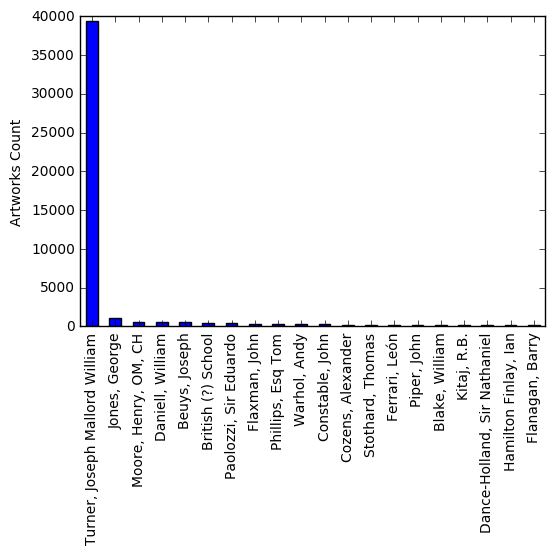

In [3]:
works.artist.value_counts().head(20).plot(kind='bar')
plt.ylabel('Artworks Count')

This plot of artworks by artists for the top 20 artists really only shows us one thing (other than providing a list of the 20 most popular artists): The Tate has a lot of works by William Turner.

If anyone knows about this history of British museums this is not a surprise. Turner, an immensely popular artist in his day, left all of his works in his possession to Britain and therefore the Tate as part of what is called The Turner Bequest. It makes up a large portion of the Tate Britain's museum in London.

To look at the relative popularity of other artists let's remove Turner.

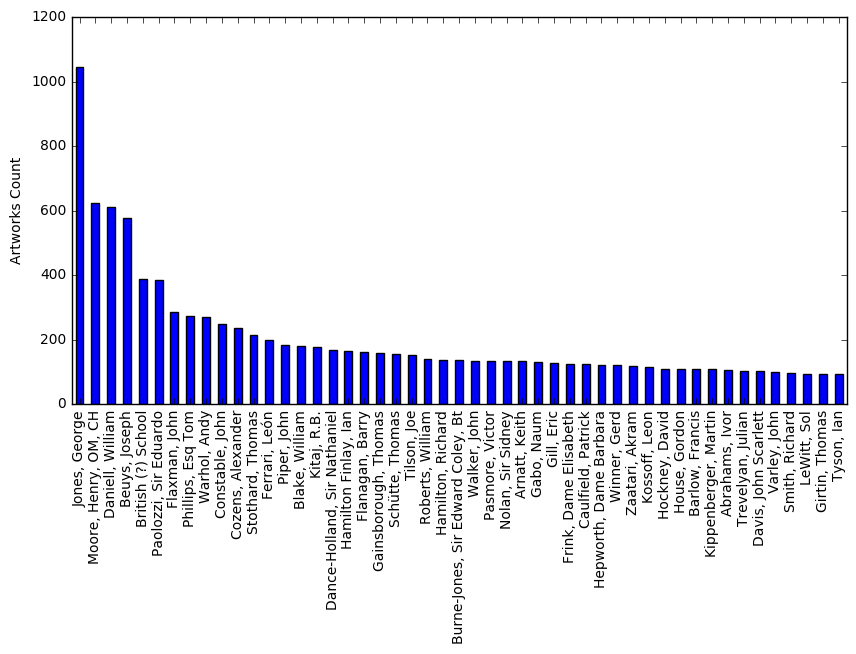

In [4]:
works.artist.value_counts().head(50)[1:51].plot(kind='bar', figsize=(10,5))
plt.ylabel('Artworks Count')

So there seem to be a few other exceptionally popular artists, with the first four or arguably six being collected in meaningfully larger numbers. I'd point out Andy Warhol's presence here as porbably one of the more currently well known artists on this list.

_Remember, this is popularity in terms of pieces collected. We have no data about visits or webviews._

__ #2 Who are the artists in the Tate collection? How does that vary by geography, age, and living or dead?__ 

In [5]:
len(artists)

3532

So there are 3,532 artists in the Tate collection. Where are they from? When looking into the where variable, there is a challenge, however. The birthplace is inconsistent. Sometimes it includes a city, others just a country.

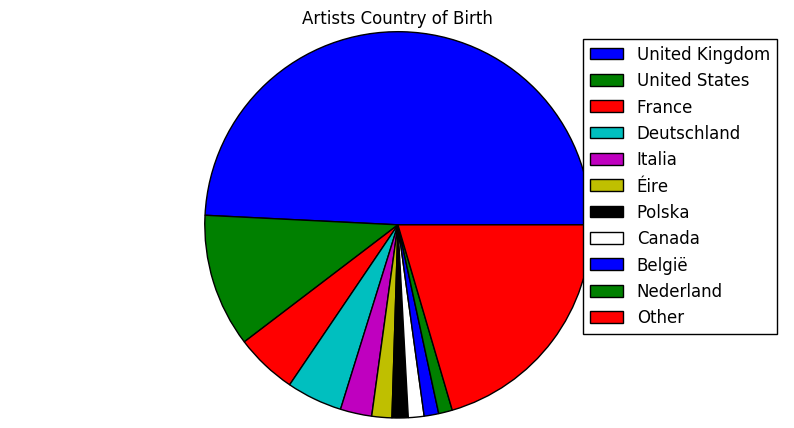

In [6]:
# Process data to create counts by country
locations = artists.placeOfBirth.str.split(',', 1).tolist()
locations = [x for x in locations if str(x) != 'nan']
countries = []
for entry in locations:
    c = entry[-1]
    c = c.strip()
    countries.append(c)
countries = pd.DataFrame(countries, columns=['country'])
cntry_counts = pd.DataFrame(countries.country.value_counts())
other = int(cntry_counts[10:].sum())
cntry_counts = cntry_counts[:10]
cntry_counts.loc[11] = other
cntry_counts = cntry_counts.rename(index={11: 'Other'})

plt.figure(figsize=(10,5))
plt.pie(cntry_counts.country)
plt.axis('equal')
plt.title('Artists Country of Birth')
plt.legend(cntry_counts.index)

So, about half of the artists in the collection are from the UK, which again is not hugely surprising as this is a British collection. The two things of note I see here are that the US and Canada are the only two non-European countries in the top 10. Also, the other countries selection is quite large, with a very large number of countries having some representation in the tate collection and making up almost a quarter of their collection.

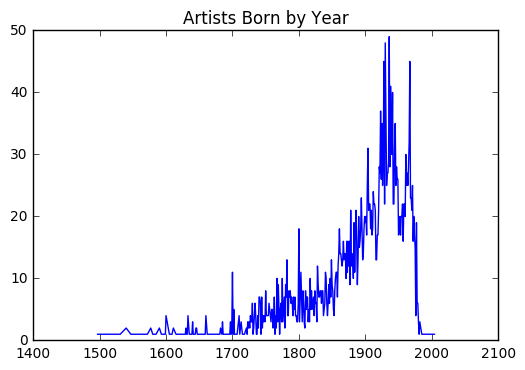

In [7]:
plt.plot(artists.yearOfBirth.value_counts().sort_index())
plt.title('Artists Born by Year')

You can see that the closer to modern times we get, the more artists we have represented. You see some interesting peaks around the centuries that are perhaps worthy of further investigation. Maybe they're using something other than artist's names to talk about movements?

How does this compare to when artworks were acquired?

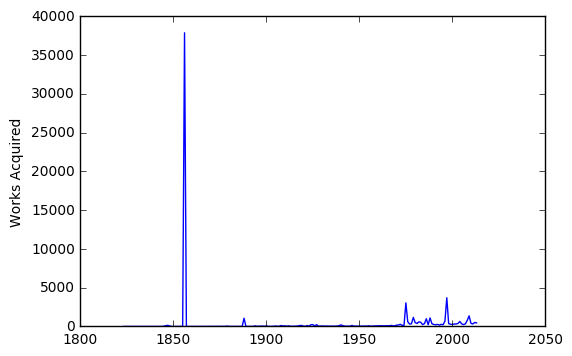

In [10]:
acquisition_df = pd.DataFrame(works.acquisitionYear.value_counts())
acquisition_df = acquisition_df.sort_index()
plt.plot(acquisition_df)
plt.ylabel('Works Acquired')

This shows a collection that seems to have several peaks in its growth. That is consistent with how museum collections tend to grow. While there is some steady acquisition, which is somewhat visible in the more modern years (though this is not a great visual of that), museums tend to see the majority of their growth from large gifts or bequests. The Turner Bequest, again, is the most visible. What does it look like without Turner?

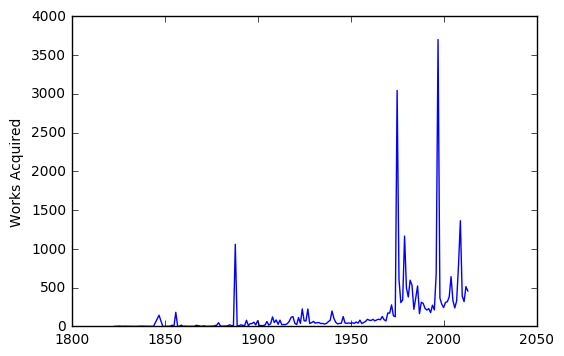

In [11]:
acquisition_df = pd.DataFrame(works[works.artist != 'Turner, Joseph Mallord William'].acquisitionYear.value_counts())
acquisition_df = acquisition_df.sort_index()
plt.plot(acquisition_df)
plt.ylabel('Works Acquired')

This shows a few more clear spikes but also a clear narrative that the collection has been growing more rapidly in recent years. This aligns with the skew towards contemporary artists.

I'm going to move on to one last subject: portion of the artists who are living. I'll use year of birth as an indicator for this. 

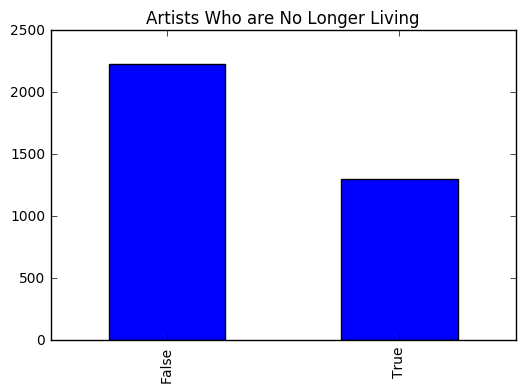

In [12]:
living = pd.DataFrame(artists.yearOfDeath.isnull())
living = pd.DataFrame(living.yearOfDeath.value_counts())
living.plot(kind='bar', legend=False)
plt.title('Artists Who are No Longer Living')

This shows a surprisingly large portion of the artists collected by the Tate are still living. However, when put into context that the Tate is one of the largest supporters of contemporary art in Britain, hosting the largest prize for contemporary art with the Turner Prize, it does fit their profile.

__#3 What are the most popular mediums and how does medium affect size?__

So it would be tempting to start with medium just as the data provides it. However, this reveals a bit of a problem.

In [13]:
works.medium.value_counts().head(10)

Graphite on paper                            26167
Oil paint on canvas                           3383
Screenprint on paper                          2984
Lithograph on paper                           2721
Watercolour on paper                          1890
Etching on paper                              1793
Graphite and watercolour on paper             1680
Ink on paper                                   880
Intaglio print on paper                        820
Photograph, gelatin silver print on paper      750
Name: medium, dtype: int64

There are way to many kinds of medium, and its with a level of subtlety that I don't really want. I grouped them together into the following.

I'm also dropping Turner here because he has 25,000 works on paper that skew all of this towards that.

In [14]:
# Remove Turner
turnerless_artworks = works[works['artist'] != 'Turner, Joseph Mallord William']
# Coerce to Numeric
turnerless_artworks.height = pd.to_numeric(turnerless_artworks.height, errors = 'coerce')
turnerless_artworks.width = pd.to_numeric(turnerless_artworks.width, errors = 'coerce')
turnerless_artworks.depth = pd.to_numeric(turnerless_artworks.depth, errors = 'coerce')
turnerless_artworks = turnerless_artworks[turnerless_artworks['units']=='mm']
turnerless_artworks = turnerless_artworks[turnerless_artworks.height.notnull()]

## The error is just because of how I did the conditional select and I'm not worried about it...

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [15]:
# Aggregate to new medium_agg column
turnerless_artworks['medium_agg'] = 'other'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("paper", na=False),'medium_agg'] = 'paper'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("canvas", na=False),'medium_agg'] = 'canvas'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("wood", na=False),'medium_agg'] = 'wood'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("paint on", na=False),'medium_agg'] = 'other painted panel'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("Bronze", na=False),'medium_agg'] = 'sculpture'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("Plaster", na=False),'medium_agg'] = 'sculpture'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("Marble", na=False),'medium_agg'] = 'sculpture'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("Stone", na=False),'medium_agg'] = 'sculpture'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("plate", na=False),'medium_agg'] = 'plate'
turnerless_artworks.loc[turnerless_artworks['medium'].str.contains("photograph", na=False),'medium_agg'] = 'photo'

turnerless_artworks['surface'] = turnerless_artworks.height * turnerless_artworks.width

In [16]:
turnerless_artworks[['medium_agg','height','width','depth','surface']].groupby('medium_agg').describe()

depth        height       surface  \
medium_agg                                                            
canvas              count     83.000000    260.000000  2.590000e+02   
                    mean     134.957831   1776.396154  3.424765e+06   
                    std      355.563519   1543.269130  3.831638e+06   
                    min        5.500000    105.000000  1.260000e+04   
                    25%       27.500000    729.250000  5.518635e+05   
                    50%       35.000000   1512.500000  2.283380e+06   
                    75%       53.000000   2290.750000  4.707936e+06   
                    max     2185.000000  16000.000000  2.173195e+07   
other               count    953.000000   1301.000000  1.298000e+03   
                    mean     761.288772   1189.179554  1.880836e+06   
                    std     1448.336740   1866.683697  4.996881e+06   
                    min        3.000000      6.000000  1.681000e+03   
                    25%      125.000000    273.000000  8.754350e+04   
                    50%      300.000000    620.000000  3.955995e+05   
                    75%      750.000000   1460.000000  1.597850e+06   
                    max    18290.000000  37500.000000  9.125394e+07   
other painted panel count    442.000000   4408.000000  4.408000e+03   
                    mean      76.997738   1032.772913  1.392090e+06   
                    std      290.694723    820.503273  2.247036e+06   
                    min        2.000000     45.000000  3.306000e+03   
                    25%       20.000000    514.000000  2.917325e+05   
                    50%       30.000000    787.000000  6.247550e+05   
                    75%       55.000000   1270.000000  1.558060e+06   
                    max     5486.000000  11900.000000  3.623310e+07   
paper               count    160.000000  19800.000000  1.978000e+04   
                    mean     277.478125    417.212288  2.608455e+05   
                    std      695.113346    379.088368  7.540381e+05   
                    min        1.000000     15.000000  2.370000e+02   
                    25%       28.250000    200.000000  3.904200e+04   
                    50%       45.000000    320.000000  1.029940e+05   
...                                 ...           ...           ...   
photo               std      467.421236   2106.887208  6.188098e+06   
                    min       18.000000     90.000000  1.332000e+04   
                    25%       25.000000    303.500000  9.896750e+04   
                    50%       39.500000    690.000000  3.884175e+05   
                    75%      146.500000   1395.250000  1.696120e+06   
                    max     2015.000000  19890.000000  5.431500e+07   
plate               count      8.000000    344.000000  3.440000e+02   
                    mean    1997.625000    347.148256  1.258063e+05   
                    std     4215.212448    478.247577  4.437804e+05   
                    min       25.000000     76.000000  7.752000e+03   
                    25%       75.000000    305.000000  6.984500e+04   
                    50%      585.500000    305.000000  6.984500e+04   
                    75%     1107.750000    305.000000  6.984500e+04   
                    max    12360.000000   8850.000000  6.549000e+06   
sculpture           count    620.000000    639.000000  6.390000e+02   
                    mean     406.875806    619.608764  6.975306e+05   
                    std      504.036311    791.822922  1.405889e+06   
                    min        8.000000     18.000000  1.296000e+03   
                    25%      152.000000    222.000000  7.777050e+04   
                    50%      270.000000    406.000000  2.032000e+05   
                    75%      445.000000    714.500000  6.622965e+05   
                    max     5800.000000  11250.000000  1.796402e+07   
wood                count    208.000000    349.000000  3.490000e+02   
                    mean     548.336538   1067.189112  2.1

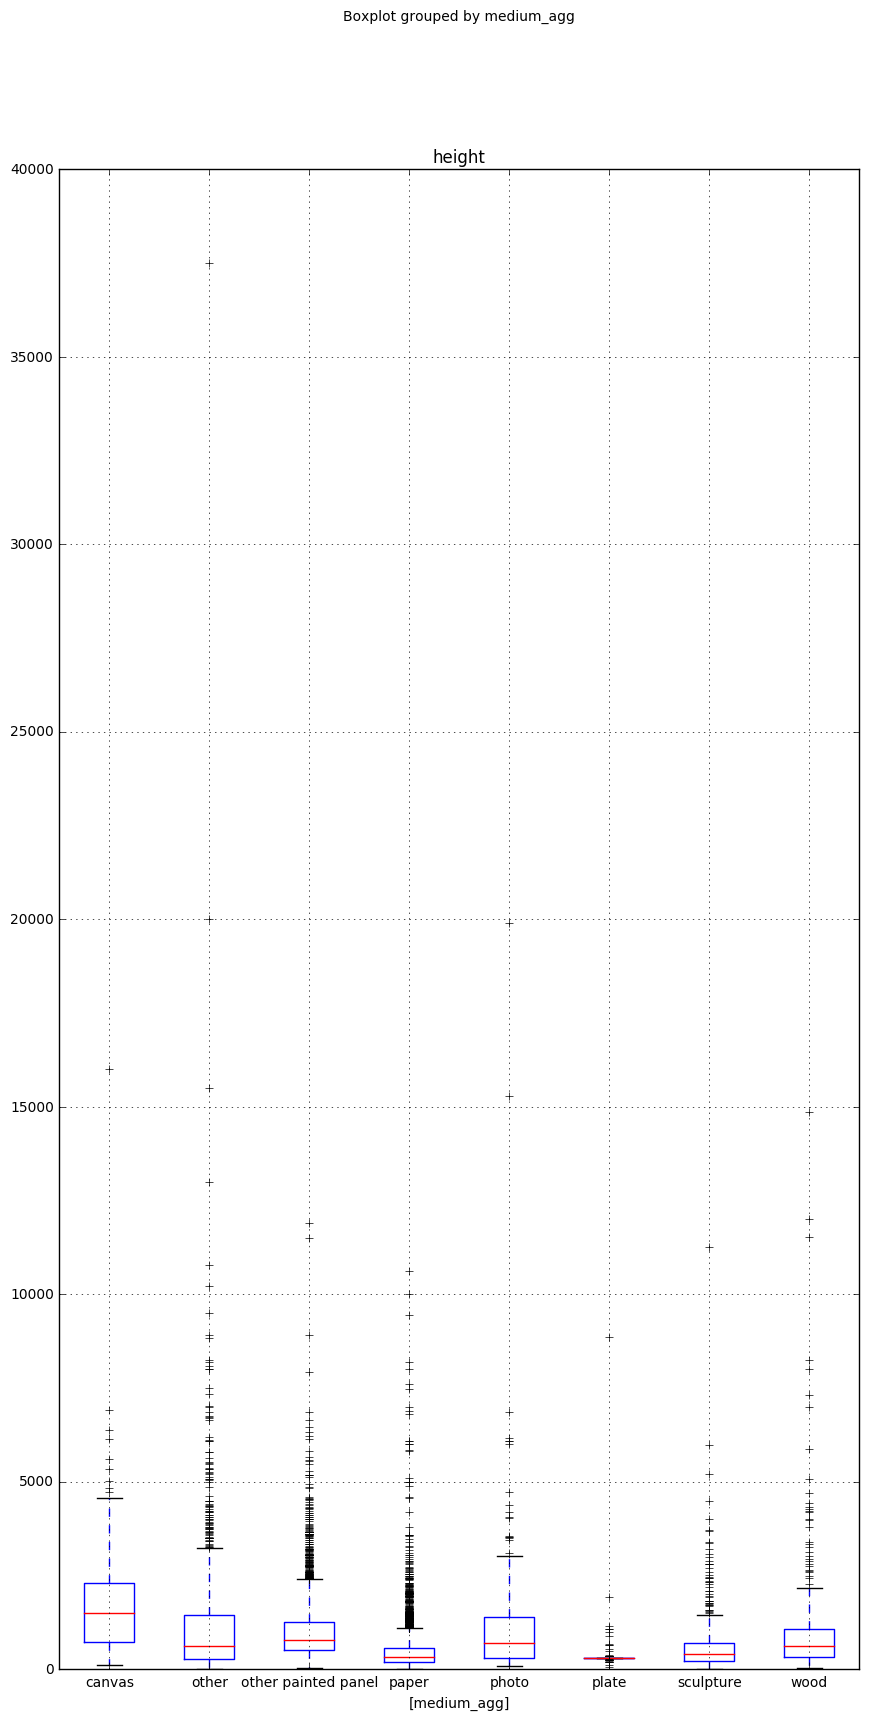

In [17]:

turnerless_artworks[['medium_agg', 'height']].boxplot(by='medium_agg', figsize=(10,20))


Now, that plot is so ghastly large that it's likely impossible to see all of it on a monitor at once. However, I wanted to keep it to make a point. There are some exceptional outliers here. The most striking is a steel piexe by Miroslaw Balka measuring 37.5 meters high! I only included one of the plots, but it would be trivial to generate the same boxplot for width, depth, and surface area. Admittedly there are also some works on paper over 10 meters high.

However, the bottom part of the plot has more generally applicable conclusions to show. Plates are almost all the same size (this is things like copper plates by the way, not ceramic). Canvas is the largest in medium and 75th percentile, and therefore also the highest whisker.

So as one would logically expect, different mediums are generally different sizes but there is huge variation in the collection, so trying to predict medium off of size could be very difficult.

Also just for fun, they have 27 works in the medium of 'ink on banknote', so that's something. It's a series by Cildo Meireles.

## Further Research

The most interesting path for further research would be to scrape the images and then use this as a labeled dataset for image recognition. The images could be labeled in era, medium, or even artist. I'd be curious if that kind of image recognition could work.

Also, it would be interested to compare multiple museum's collections to see how age of the collection and geography have affected collecting, even of artists from the other countries.